In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%matplotlib inline

Considere um canal de comunicações cuja entrada é um sinal $x[k]$ e cuja saída é um sinal $r[k] = x[k-\delta] + n[k]$. Ou seja, a saída é uma versão ruidosa e atrasada da entrada. Seu objetivo aqui é determinar o valor do atraso $\delta$.

Para isso, vamos fazer algumas hipóteses. O sinal transmitido será composto de 10 valores consecutivos iguas a 1, sendo o restante igual a zero.

<StemContainer object of 3 artists>

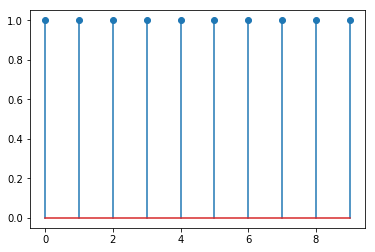

In [3]:
x = np.ones(10)
plt.stem(x)

A segunda hipótese é que o atraso é aleatório, sendo modelado como uma variável aleatória uniformemente distribuída entre 0 e 100 amostras.

In [4]:
d = np.random.randint(0, 100 + 1)
print(d)

49


Finalmente, vamos assumir que o ruído é normal, com média zero e variância $\sigma^2$, independente e identicamente distruído.

Observe que, como o atraso varia de 1 a cem amostras, é necessário observar uma janela 111 amostras do sinal recebido para termos certeza de que o sinal x foi observado dentro da janela.

<StemContainer object of 3 artists>

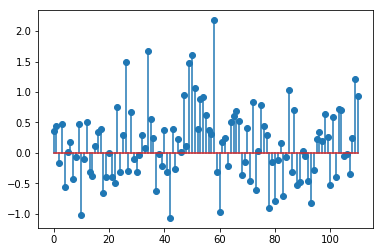

In [5]:
sigma = .5
r = sigma*np.random.randn(111)
r[d:(d+10)] += x
plt.stem(r)

Para determinar o atraso, você vai usar uma estratégia chamada máximo a posteriori: o valor de $\delta$ é aquele que é o mais provável no mundo em que o sinal $r[k]$ é observado. Para facilitar nossa notação, seja $\mathbf{r}$ um vetor contendo todas as 111 amostras de $r[k]$. Assim, o valor de $\delta$ será dado por
$$\delta_{\mathrm{ótimo}} = \arg\max_{\delta} p_{\Delta|\mathbf{R}}(\delta|\mathbf{r})$$

Determine e implemente este detector. Busque fazer o maior número possível de simplificações. Você verá que existem diversas probabilidades e diversas funções que não precisam ser calculadas.

Imagine agora que o valor de $\delta$ seja 10. Calcule analiticamente e por simulação a probabilidade de seu detector ''preferir'' o valor de $\delta = 11$ ao invés do valor correto. Ou seja, calcule a probabilidade de $$p_{\Delta|\mathbf{R}}(11|\mathbf{R}) \gt p_{\Delta|\mathbf{R}}(10|\mathbf{R})$$

## Resolução

Queremos calcular $\zeta_{0}$ tal que

$$ \zeta_{0} = \arg\max_{\zeta} p_{\mathcal{Z}|\mathbf{R}}(\zeta|\mathbf{r}) = 
\arg\max_{\zeta} \frac{f_{\mathbf{R}|\mathcal{Z}}(\mathbf{r}|\zeta)p(\zeta)}{{f(\mathbf{r})}}  $$

Para isso, sabemos que $p_{\mathcal{Z}}(\zeta) = \frac{1}{101}$ e temos que, dado $\zeta$ e definindo $\delta_{\zeta}^{\theta}$
como o trem de impulsos de comprimento $\theta$ começando na posição $\zeta$:

$$ f_{\mathbf{R}|\mathcal{Z}}(\mathbf{r}|\zeta) = f_{N(0, \sigma^2)}(\mathbf{r} - \delta_{\zeta}^{\theta}|\zeta)$$

Sabemos ainda que $f_{\mathbf{R}}(\mathbf{r})$ é invariante em $\zeta$, de modo que pode ser ignorado durante a escolha do valor ótimo
de $\zeta$. Como todas as amostras do ruído gaussiano são independentes e unicamente distribuídas, o processo é, então, equivalente a escolher

$$\zeta_{0} = \arg\max_{\zeta} f_{\mathbf{R}|\mathcal{Z}}(\mathbf{r}|\zeta) 
            = \arg\max_{\zeta} \prod_{i=0}^{110} f_{N(0, \sigma^2)}(\mathbf{r}[i] - \delta_{\zeta}^{\theta}[i])
            = \arg\min_{\zeta} \sum_{i=0}^{110} (\mathbf{r}[i] - \delta_{\zeta}^{\theta}[i])$$



In [6]:
def find_delay(noisy_signal, noise_cardinality, signal_length, signal=None):
    if signal is None:
        signal = np.ones(signal_length)
    min_arg = np.inf
    opt_zeta = None

    for zeta in range(0, noise_cardinality - 1):
        s = noisy_signal.copy()
        s[zeta:zeta + train_len] -= signal
        arg = np.square(s).sum()
        opt_zeta = zeta if arg < min_arg else opt_zeta
        min_arg = arg if arg < min_arg else min_arg
    return opt_zeta

In [7]:
card_delta = 100
train_len = 10
sigma = .5

d = np.random.randint(0, card_delta + 1)
r = sigma*np.random.randn(card_delta + train_len)
r[d:(d+train_len)] += np.ones(train_len)

zeta = find_delay(r, card_delta, train_len)

print("Delay:", d)
print("Delay encontrado", zeta)
print("Delay certo:", d == zeta)

Delay: 73
Delay encontrado 72
Delay certo: False


## Qual a probabilidade de errar para cima por uma amostra?
1. Para simular essa probabilidade, utilizaremos a abordagem mais direta possível: realização de diversos experimentos e contabilização da
quantidade de eventos nos quais ocorre o evento que queremos. A frequência relativa desse evento se aproxima da probabilidade do evento
com o crescimento do número de realizações do experimento.
2. A solução analítica desse problema é 
$$
P(P(\zeta|R)) < P(\zeta + 1|R)) 
= P(f(R|10) < f(R|11)) 
= P(R[20] > R[10])
= \int_{R[10]}^{R[20]}f_N(x)dx
= \int_{R[10]}^{R[20]} \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{x^2}{2\sigma^2}} dx
$$

In [8]:
num_trials = 1000000 # 1 Million
count_error_by_one_above = 0
count_correct = 0

@numba.jit(nopython=True, nogil=True, fastmath=True, cache=True)
def generate_arrays(delta_cardinality, train_length):
    d = np.random.randint(0, delta_cardinality + 1)
    r = sigma*np.random.randn(delta_cardinality + train_length)
    r[d:(d+train_length)] += np.ones(train_length)
    return r, d
    
@numba.jit(nopython=True, nogil=True, fastmath=True, cache=True)
def sim_experiment(r, d):
    args = []
    for zeta in range(0, card_delta - 1):
        s = r.copy()
        s[zeta:zeta + train_len] -= np.ones(train_len)
        arg = np.square(s).sum()
        args.append(arg)
    return args

for _ in tqdm(range(num_trials)):
    r, d = generate_arrays(card_delta, train_len)
    args = sim_experiment(r, d)
    zeta = np.argmin(args)
    count_error_by_one_above += (zeta == d + 1)
    count_correct += (zeta == d)

100%|███████████████████████████████████████████| 1000000/1000000 [01:27<00:00, 11472.40it/s]


In [9]:
print("Número de acertos: {}/{} ({}%)".format(count_correct,
                                              num_trials,
                                              count_correct/num_trials * 100))
print("Número de erros com uma amostra para cima de confusão: {}/{} ({}%)".format(
    count_error_by_one_above, num_trials, count_error_by_one_above/num_trials * 100)
)

Número de acertos: 815668/1000000 (81.5668%)
Número de erros com uma amostra para cima de confusão: 66474/1000000 (6.6474%)


In [10]:
est_p_one_above = count_error_by_one_above / num_trials
est_p_correct = count_correct / num_trials
est_p_correct, est_p_one_above

(0.815668, 0.066474)